93 1305


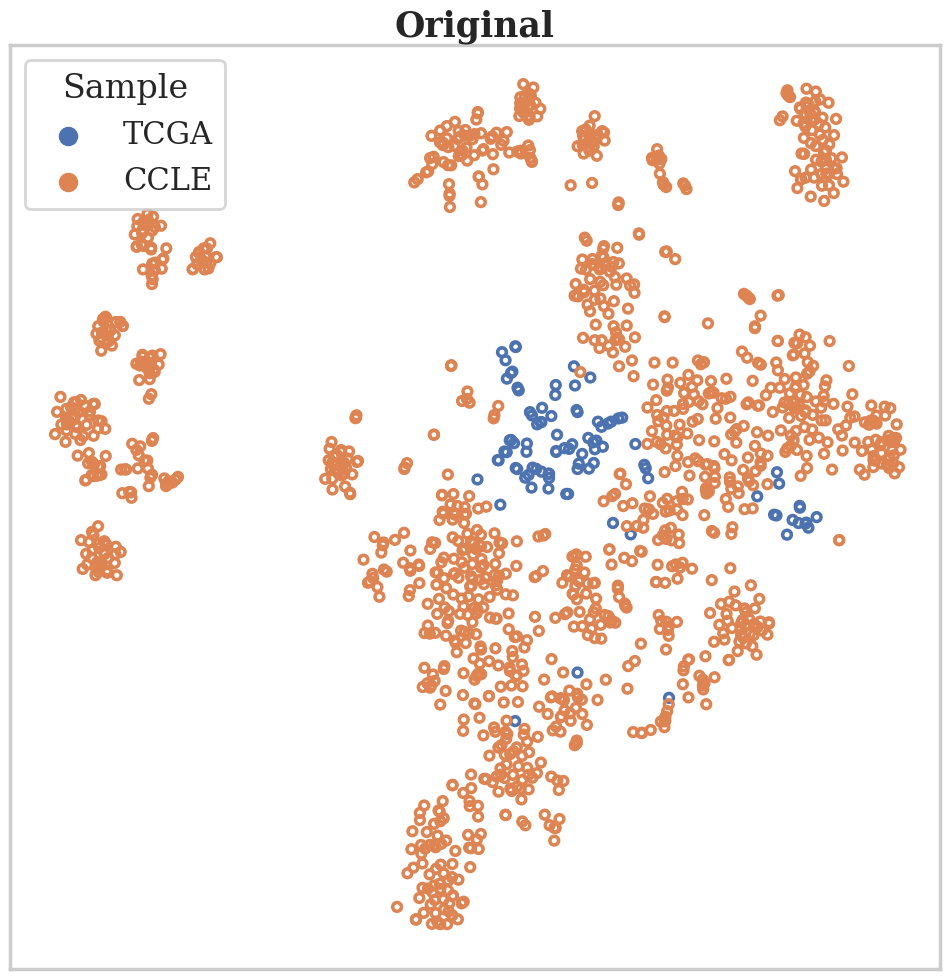

In [12]:
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn import manifold


import data
import data_config


pretrain_dataset = ["tcga","brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
          "luad", "lusc", "read", "sarc", "skcm","stad"][10]  ##用于预训练的方式
# TT = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
#           "luad", "lusc", "read", "sarc", "skcm","stad"][1]    ##选中要做zero-shot验证的癌种


tsne = manifold.TSNE(n_components=2, init='random',random_state=0)
ori_gex = pd.read_csv(f'../data/align_data/{pretrain_dataset}_pretrain_dataset.csv', index_col=0)
patient_num = ori_gex.index.str.startswith('TCGA').sum()
cell_line_num = ori_gex.index.str.startswith('ACH').sum()
print(patient_num,cell_line_num)
gex_label = ['TCGA'] * patient_num + ['CCLE'] * cell_line_num

ori_gex_y = tsne.fit_transform(ori_gex)
ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
ori_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set(font_scale = 2.0)
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


ax = sns.scatterplot(x='x',y='y',data=ori_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('Original', fontsize=25, weight='bold')
plt.show()
#plt.savefig(f'../intermediate_results/encoded_features/Original_tSNE.png', format='png', dpi=350,bbox_inches='tight')


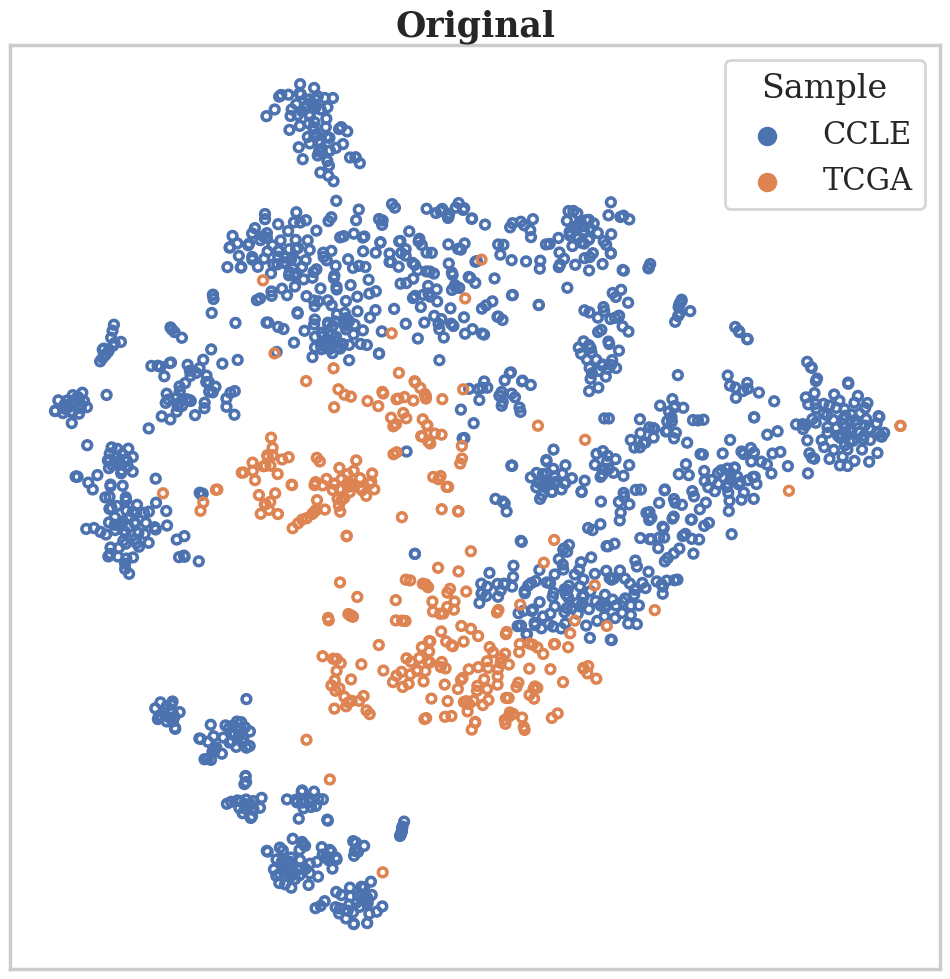

In [30]:
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn import manifold


import data
import data_config

pretrain_mode = ["tcga","match"][1]
pretrain_method = ['ae','dsrn', 
                       'ae_mmd','dsrn_mmd','dsn_mmd',
                       'ae_adv','dsrn_adv','dsn_adv'][1]
# pretrain_dataset = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
#           "luad", "lusc", "read", "sarc", "skcm","stad"][10]  ##用于预训练的方式
TT = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
          "luad", "lusc", "read", "sarc", "skcm","stad"][1]    ##选中要做zero-shot验证的癌种


tsne = manifold.TSNE(n_components=2, init='random',random_state=0)
ori_gex = pd.read_csv(f'../data/align_data/{pretrain_mode}/{pretrain_method}/{TT}.csv', index_col=0)

gex_label = ori_gex.label.values
# gex_label[gex_label=="TCGA"] = TT.upper()
del ori_gex['label']
ori_gex_y = tsne.fit_transform(ori_gex)
ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
ori_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set(font_scale = 2.0)
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


ax = sns.scatterplot(x='x',y='y',data=ori_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('Original', fontsize=25, weight='bold')
plt.show()
#plt.savefig(f'../intermediate_results/encoded_features/Original_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [33]:
ori_encoder_feature_df

,x,y,Sample
0,-25.568722,7.707081,CCLE
1,-17.853430,-41.707653,CCLE
2,-19.110605,-41.760433,CCLE
3,-18.753796,-42.061455,CCLE
4,-7.428963,-47.936245,CCLE
...,...,...,...
1545,3.118765,-5.464332,TCGA
1546,3.162210,-5.472980,TCGA
1547,-2.358491,8.811005,TCGA
1548,12.950588,-9.053420,TCGA


In [68]:
#得到ccle_samples -》 看1244个ccl属于哪个癌种
gex_features_df = pd.read_csv('../data/align_data/brca_pretrain_dataset.csv',index_col = 0)
ccle_sample_info_df = pd.read_csv(data_config.ccle_sample_file, index_col=0)
ccle_sample_info_df = ccle_sample_info_df.reset_index().drop_duplicates(subset="Depmap_id",keep='first').set_index("Depmap_id")

ccle_samples = ccle_sample_info_df.index.intersection(gex_features_df.index)
ccle_samples
Tumor_type_info = ccle_sample_info_df.loc[ccle_samples]['tumor_type'].values
Tumor_type_info

array(['ACC', 'ALL', 'ALL', ..., 'UVM', 'UVM', 'UVM'], dtype=object)

In [95]:
pd.DataFrame(Tumor_type_info).value_counts()

LUAD                  111
SARC                   78
GBM                    72
COAD                   67
SKCM                   63
BRCA                   59
DLBC                   59
OV                     57
SCLC                   51
PAAD                   51
HNSC                   45
LAML                   41
STAD                   41
BLCA                   39
ALL                    37
Non-Cancerous          35
CHOL                   34
KIRC                   33
ESCA                   32
MM                     30
UCEC                   30
LUSC                   28
NB                     26
LIHC                   24
MESO                   17
CESC                   16
LCML                   14
THCA                   11
MB                      8
PRAD                    7
UVM                     6
Gallbladder cancer      6
cSCC                    5
ATRT                    5
CLL                     4
UCS                     1
ACC                     1
dtype: int64

0
1
2
3
4


array([[ 5.08491895,  2.33061257,  6.84722555,  2.38518329],
       [ 9.15553182,  8.08514188,  9.84053902, 10.91041184],
       [ 8.29908368, 10.26472576,  8.77721677,  9.22501508],
       [ 7.3961008 , 11.1398112 , 10.87521062,  9.21526497],
       [ 1.17205951,  3.48164382,  8.3928754 ,  1.82345615]])

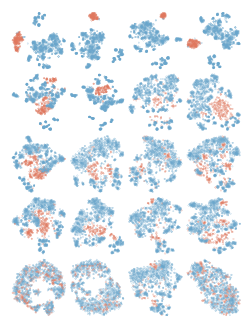

In [12]:
pretrain_mode = ["tcga","match"][1]


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import entropy
import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 0.2
# # 设置字体
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
# plt.rcParams['font.family'] = 'Arial'

sigma = 1.0
def compute_mmd(A, B, sigma):
    # 计算高斯核矩阵
    K_A = np.exp(-cdist(A, A, 'sqeuclidean') / (2 * sigma ** 2))
    K_B = np.exp(-cdist(B, B, 'sqeuclidean') / (2 * sigma ** 2))
    K_AB = np.exp(-cdist(A, B, 'sqeuclidean') / (2 * sigma ** 2))
    # 计算 MMD
    return np.mean(K_A) + np.mean(K_B) - 2 * np.mean(K_AB)

def compute_kl_divergence(A, B):
    # Compute the probability density functions and add a small value to avoid zeros
    p_A = np.histogramdd(A, bins=10, density=True)[0] + 1e-10
    p_B = np.histogramdd(B, bins=10, density=True)[0] + 1e-10
    
    # Normalize the histograms to have a unit sum
    p_A = p_A / np.sum(p_A)
    p_B = p_B / np.sum(p_B)
    
    # Ensure the histograms have the same shape and dimensionality
    p_A = p_A.flatten()
    p_B = p_B.flatten()
    
    # Compute KL divergence
    kl_div = np.sum(p_A * np.log(p_A / p_B))
    
    return kl_div


# 创建一个 5 行 5 列的子图
x_num , y_num = 5,4
fig, axs = plt.subplots(x_num , y_num,figsize=(3,4))

MMD = np.empty((x_num,y_num))
# MMD2 = np.empty((x_num,y_num))
KL = np.empty((x_num,y_num))


ccle_color = '#69A6CC'
patient_color = '#E0785E'

# 填充每个子图
for j in range(x_num):
    print(j)
    for i in range(y_num):
         TT = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
            "luad", "lusc", "read", "sarc", "skcm","stad"][i] 
         TT = [ "cesc", "gbm",  "read",  "skcm"][i]
         pretrain_method = ['original','ae','dsrn', 
                        # 'ae_mmd','dsrn_mmd',
                        'dsn_mmd',
                        # 'ae_adv','dsrn_adv',
                        'dsn_adv'][j]
         tsne = manifold.TSNE(n_components=2, init='random',random_state=0)
         if pretrain_method == 'original':
            ori_gex = pd.read_csv(f'../data/align_data/orginal/{TT}_dataset.csv', index_col=0)
            patient_num = ori_gex.index.str.startswith('TCGA').sum()
            cell_line_num = ori_gex.index.str.startswith('ACH').sum()
            # print(patient_num,cell_line_num)
            color = np.array([patient_color] * patient_num + [ccle_color] * cell_line_num)
         else:
            ori_gex = pd.read_csv(f'../data/align_data/{pretrain_mode}/{pretrain_method}/{TT}.csv', index_col=0)

            gex_label = ori_gex.label.values
            color = np.array([ccle_color] * sum(gex_label == "CCLE") + [patient_color] * sum(gex_label == "TCGA"))
            
            # if TT == "lgg":
            #    TT = "gbm"

            # color[np.where(Tumor_type_info == TT.upper())[0]] = 'r'
            # print(TT,sum(color == 'r'))
            # gex_label[gex_label=="TCGA"] = TT.upper()
            del ori_gex['label']
         ori_gex_y = tsne.fit_transform(ori_gex)
         ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
         ccle_feature_df = np.array(ori_encoder_feature_df.loc[color == ccle_color])
         patient_feature_df = np.array(ori_encoder_feature_df.loc[color == patient_color]) #EE9D80
         mmd = compute_mmd(ccle_feature_df, patient_feature_df, sigma)
         # # mmd2 = compute_mmd(patient_feature_df,ccle_feature_df, sigma)
         kl_divergence = compute_kl_divergence(ccle_feature_df,patient_feature_df)
         MMD[j,i] = mmd
         # MMD2[i,j] = mmd2
         KL[j,i] = kl_divergence

         axs[j,i].scatter(x='x',y='y',data=ori_encoder_feature_df,c=color,s=0.02,alpha=1, marker='o')
         # axs[i, j].set_title(TT)
         axs[j,i].set_axis_off()

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# 显示图形
# plt.show()

plt.savefig(f'../data/align_data/{pretrain_mode}.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.savefig(f'../data/align_data/{pretrain_mode}.png', format='png', dpi=1200,bbox_inches='tight')

# arr = MMD
# arr = np.concatenate([arr, arr[:, 0:1] / arr[:, 5:6]], axis=1)
# arr
KL

0
1
2
3
4


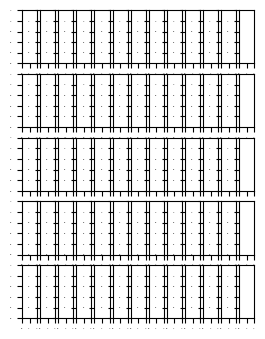

In [3]:
#跑所有的（13）的 MMD 和 KL散度
pretrain_mode = ["tcga","match"][1]


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import entropy
import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 0.2
# # 设置字体
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
# plt.rcParams['font.family'] = 'Arial'

sigma = 1.0
def compute_mmd(A, B, sigma):
    # 计算高斯核矩阵
    K_A = np.exp(-cdist(A, A, 'sqeuclidean') / (2 * sigma ** 2))
    K_B = np.exp(-cdist(B, B, 'sqeuclidean') / (2 * sigma ** 2))
    K_AB = np.exp(-cdist(A, B, 'sqeuclidean') / (2 * sigma ** 2))
    # 计算 MMD
    return np.mean(K_A) + np.mean(K_B) - 2 * np.mean(K_AB)

def compute_kl_divergence(A, B):
    # Compute the probability density functions and add a small value to avoid zeros
    p_A = np.histogramdd(A, bins=10, density=True)[0] + 1e-10
    p_B = np.histogramdd(B, bins=10, density=True)[0] + 1e-10
    
    # Normalize the histograms to have a unit sum
    p_A = p_A / np.sum(p_A)
    p_B = p_B / np.sum(p_B)
    
    # Ensure the histograms have the same shape and dimensionality
    p_A = p_A.flatten()
    p_B = p_B.flatten()
    
    # Compute KL divergence
    kl_div = np.sum(p_A * np.log(p_A / p_B))
    
    return kl_div


# 创建一个 5 行 5 列的子图
x_num , y_num = 5,13
fig, axs = plt.subplots(x_num , y_num,figsize=(3,4))

MMD = np.empty((x_num,y_num))
# MMD2 = np.empty((x_num,y_num))
KL = np.empty((x_num,y_num))


ccle_color = '#69A6CC'
patient_color = '#E0785E'

# 填充每个子图
for j in range(x_num):
    print(j)
    for i in range(y_num):
         TT = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
            "luad", "lusc", "read", "sarc", "skcm","stad"][i] 
        #  TT = [ "cesc", "gbm",  "read",  "skcm"][i]
         pretrain_method = ['original','ae','dsrn', 
                        # 'ae_mmd','dsrn_mmd',
                        'dsn_mmd',
                        # 'ae_adv','dsrn_adv',
                        'dsn_adv'][j]
         tsne = manifold.TSNE(n_components=2, init='random',random_state=0)
         if pretrain_method == 'original':
            ori_gex = pd.read_csv(f'../data/align_data/orginal/{TT}_dataset.csv', index_col=0)
            patient_num = ori_gex.index.str.startswith('TCGA').sum()
            cell_line_num = ori_gex.index.str.startswith('ACH').sum()
            # print(patient_num,cell_line_num)
            color = np.array([patient_color] * patient_num + [ccle_color] * cell_line_num)
         else:
            ori_gex = pd.read_csv(f'../data/align_data/{pretrain_mode}/{pretrain_method}/{TT}.csv', index_col=0)

            gex_label = ori_gex.label.values
            color = np.array([ccle_color] * sum(gex_label == "CCLE") + [patient_color] * sum(gex_label == "TCGA"))
            
            # if TT == "lgg":
            #    TT = "gbm"

            # color[np.where(Tumor_type_info == TT.upper())[0]] = 'r'
            # print(TT,sum(color == 'r'))
            # gex_label[gex_label=="TCGA"] = TT.upper()
            del ori_gex['label']
         ori_gex_y = tsne.fit_transform(ori_gex)
         ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
         ccle_feature_df = np.array(ori_encoder_feature_df.loc[color == ccle_color])
         patient_feature_df = np.array(ori_encoder_feature_df.loc[color == patient_color]) #EE9D80
         mmd = compute_mmd(ccle_feature_df, patient_feature_df, sigma)
         # # mmd2 = compute_mmd(patient_feature_df,ccle_feature_df, sigma)
         kl_divergence = compute_kl_divergence(ccle_feature_df,patient_feature_df)
         MMD[j,i] = mmd
         # MMD2[i,j] = mmd2
         KL[j,i] = kl_divergence

#          axs[j,i].scatter(x='x',y='y',data=ori_encoder_feature_df,c=color,s=0.02,alpha=1, marker='o')
#          # axs[i, j].set_title(TT)
#          axs[j,i].set_axis_off()

# # 调整子图之间的间距
# plt.subplots_adjust(wspace=0.01, hspace=0.01)

# # 显示图形
# # plt.show()

# plt.savefig(f'../data/align_data/{pretrain_mode}.pdf', format='pdf', dpi=1200,bbox_inches='tight')
# plt.savefig(f'../data/align_data/{pretrain_mode}.png', format='png', dpi=1200,bbox_inches='tight')

# # arr = MMD
# # arr = np.concatenate([arr, arr[:, 0:1] / arr[:, 5:6]], axis=1)
# # arr
# KL

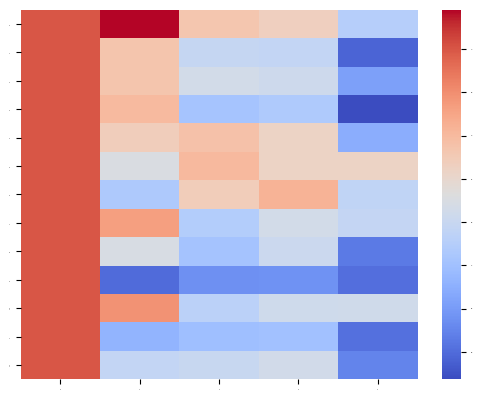

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

arr_MMD = MMD / MMD[[0],:]

sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(arr_MMD.T, cmap='coolwarm')
plt.savefig('../data/align_data/MMD.pdf', format='pdf', dpi=1200,bbox_inches='tight')

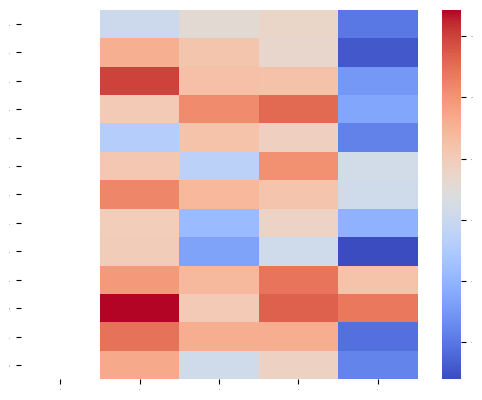

In [7]:
arr_KL = KL
arr_KL[[0],:] = "nan"

sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(arr_KL.T, cmap='coolwarm')
plt.savefig('../data/align_data/KL.pdf', format='pdf', dpi=1200,bbox_inches='tight')

In [6]:
arr = [MMD,KL][0]
arr = arr / arr[[0],:]
arr

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.09128406, 0.76780549, 0.76853288, 0.79840148, 0.73787551,
        0.65248884, 0.53129999, 0.86727826, 0.64652722, 0.29976447,
        0.89321576, 0.46183123, 0.58630973],
       [0.76622188, 0.59332295, 0.62884287, 0.51280564, 0.77762721,
        0.80227487, 0.74370146, 0.54680072, 0.50962715, 0.37554634,
        0.56483904, 0.49435794, 0.59775089],
       [0.7326613 , 0.5871369 , 0.61703598, 0.53497728, 0.71782376,
        0.71869548, 0.81995795, 0.62723358, 0.61017816, 0.37923117,
        0.62028472, 0.50299892, 0.62600553],
       [0.55280759, 0.283597  , 0.41236046, 0.23660447, 0.44458595,
        0.71749089, 0.57975115, 0.58737156, 0.328724  , 0.30473484,
        0.62320539, 0.30970107, 0.34976392]])

In [ ]:
import numpy as np
import pandas as pd
z = pd.DataFrame(
         np.array([[1.09128406, 0.76780549, 0.76853288, 0.79840148, 0.73787551,
        0.65248884, 0.53129999, 0.86727826, 0.64652722, 0.29976447,
        0.89321576, 0.46183123, 0.58630973],
       [0.76622188, 0.59332295, 0.62884287, 0.51280564, 0.77762721,
        0.80227487, 0.74370146, 0.54680072, 0.50962715, 0.37554634,
        0.56483904, 0.49435794, 0.59775089],
       [0.7326613 , 0.5871369 , 0.61703598, 0.53497728, 0.71782376,
        0.71869548, 0.81995795, 0.62723358, 0.61017816, 0.37923117,
        0.62028472, 0.50299892, 0.62600553],
       [0.55280759, 0.283597  , 0.41236046, 0.23660447, 0.44458595,
        0.71749089, 0.57975115, 0.58737156, 0.328724  , 0.30473484,
        0.62320539, 0.30970107, 0.34976392]]),
        columns = [i.upper() for i in ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
            "luad", "lusc", "read", "sarc", "skcm","stad"] ],
        index = ['ae','dsrn', 'dsn_mmd','dsn_adv']
)

z.to_csv('../data/align_data/comp/MMD.csv')

y = pd.DataFrame( np.array([
       [ 9.15553182,  8.08514188,  9.84053902, 10.91041184],
       [ 8.29908368, 10.26472576,  8.77721677,  9.22501508],
       [ 7.3961008 , 11.1398112 , 10.87521062,  9.21526497],
       [ 1.17205951,  3.48164382,  8.3928754 ,  1.82345615]]),
        columns = [i.upper() for i in [ "cesc", "gbm",  "read",  "skcm"] ],
        index = ['ae','dsrn', 'dsn_mmd','dsn_adv'] )
y.to_csv('../data/align_data/comp/KL.csv')

array([[0.00859517, 0.00856369, 0.00806802, 0.00927829, 0.0077618 ,
        0.00473569, 1.00367603],
       [0.00826631, 0.01639798, 0.01336881, 0.01554239, 0.00971022,
        0.01352428, 0.50410541],
       [0.00822475, 0.01570343, 0.01404473, 0.01794195, 0.01265279,
        0.01294019, 0.52375508],
       [0.01035524, 0.01609804, 0.02174846, 0.02304405, 0.01883143,
        0.01817091, 0.6432611 ],
       [0.0068184 , 0.01163977, 0.01092314, 0.01106013, 0.00979194,
        0.00975818, 0.58578529],
       [0.00667829, 0.01178018, 0.00995674, 0.01034743, 0.01093391,
        0.0109815 , 0.56690885],
       [0.00660965, 0.01351107, 0.0093938 , 0.0137144 , 0.01035558,
        0.00981146, 0.48920302],
       [0.00668373, 0.01075113, 0.00955753, 0.01043008, 0.00876816,
        0.00609155, 0.62167733],
       [0.00685277, 0.00851235, 0.00862269, 0.01047391, 0.00844978,
        0.008767  , 0.80503913],
       [0.01636872, 0.0289139 , 0.02754689, 0.02522336, 0.02280648,
        0.03069436, 0.5

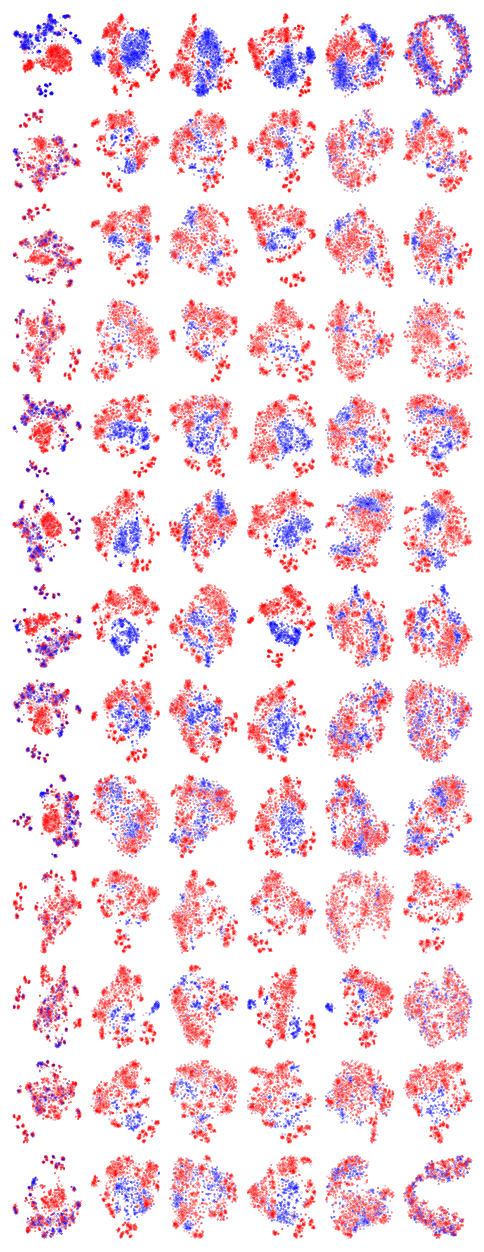

In [ ]:
pretrain_mode = ["tcga","match"][0]


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import entropy

plt.rcParams['font.size'] = 0.2
# # 设置字体
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
# plt.rcParams['font.family'] = 'Arial'

sigma = 1.0
def compute_mmd(A, B, sigma):
    # 计算高斯核矩阵
    K_A = np.exp(-cdist(A, A, 'sqeuclidean') / (2 * sigma ** 2))
    K_B = np.exp(-cdist(B, B, 'sqeuclidean') / (2 * sigma ** 2))
    K_AB = np.exp(-cdist(A, B, 'sqeuclidean') / (2 * sigma ** 2))
    # 计算 MMD
    return np.mean(K_A) + np.mean(K_B) - 2 * np.mean(K_AB)

def compute_kl_divergence(A, B):
    # 计算分布的概率密度函数
    p_A = np.histogramdd(A, bins=10, density=True)[0]
    p_B = np.histogramdd(B, bins=10, density=True)[0]
    # 计算 KL 散度
    return entropy(p_A.flatten(), p_B.flatten())

# 创建一个 5 行 5 列的子图
x_num , y_num = 13,6
fig, axs = plt.subplots(x_num , y_num,figsize=(6, 16))

MMD = np.empty((x_num,y_num))
# MMD2 = np.empty((x_num,y_num))
KL = np.empty((x_num,y_num))

# 填充每个子图
for i in range(x_num):
    for j in range(y_num):
         TT = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
            "luad", "lusc", "read", "sarc", "skcm","stad"][i] 
         pretrain_method = ['original','dsrn', 
                     #    'ae_mmd',
                        'dsrn_mmd','dsn_mmd',
                     #    'ae_adv',
                        'dsrn_adv','dsn_adv'][j]
         tsne = manifold.TSNE(n_components=2, init='random',random_state=0)
         if pretrain_method == 'original':
            ori_gex = pd.read_csv(f'../data/align_data/{TT}_pretrain_dataset.csv', index_col=0)
            patient_num = ori_gex.index.str.startswith('TCGA').sum()
            cell_line_num = ori_gex.index.str.startswith('ACH').sum()
            # print(patient_num,cell_line_num)
            color = np.array(['r'] * cell_line_num + ['b'] * patient_num)
         else:
            ori_gex = pd.read_csv(f'../data/align_data/{pretrain_mode}/{pretrain_method}/{TT}.csv', index_col=0)

            gex_label = ori_gex.label.values
            color = np.array(['r'] * sum(gex_label == "CCLE") + ['b'] * sum(gex_label == "TCGA"))
            
            # if TT == "lgg":
            #    TT = "gbm"

            # color[np.where(Tumor_type_info == TT.upper())[0]] = 'r'
            # print(TT,sum(color == 'r'))
            # gex_label[gex_label=="TCGA"] = TT.upper()
            del ori_gex['label']
         ori_gex_y = tsne.fit_transform(ori_gex)
         ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
         ccle_feature_df = np.array(ori_encoder_feature_df.loc[color == 'r'])
         patient_feature_df = np.array(ori_encoder_feature_df.loc[color == 'b'])
         mmd = compute_mmd(ccle_feature_df, patient_feature_df, sigma)
         # mmd2 = compute_mmd(patient_feature_df,ccle_feature_df, sigma)
         kl_divergence = compute_kl_divergence(ccle_feature_df,patient_feature_df)
         MMD[i,j] = mmd
         # MMD2[i,j] = mmd2
         KL[i,j] = kl_divergence

         axs[i, j].scatter(x='x',y='y',data=ori_encoder_feature_df,c=color,s=0.02,alpha=1, marker='o')
         # axs[i, j].set_title(TT)
         axs[i,j].set_axis_off()

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# 显示图形
# plt.show()

plt.savefig(f'../data/align_data/{pretrain_mode}.pdf', format='pdf', dpi=600,bbox_inches='tight')
arr = MMD
arr = np.concatenate([arr, arr[:, 0:1] / arr[:, 5:6]], axis=1)
arr

In [38]:
arr = MMD
arr = np.concatenate([arr, arr[:, 0:1] / arr[:, 5:6]], axis=1)
arr

array([[0.00859517, 0.00856369, 0.00806802, 0.00927829, 0.0077618 ,
        0.00473569, 1.81497614],
       [0.00826631, 0.01639798, 0.01336881, 0.01554239, 0.00971022,
        0.01352428, 0.61122007],
       [0.00822475, 0.01570343, 0.01404473, 0.01794195, 0.01265279,
        0.01294019, 0.6355974 ],
       [0.01035524, 0.01609804, 0.02174846, 0.02304405, 0.01883143,
        0.01817091, 0.56988007],
       [0.0068184 , 0.01163977, 0.01092314, 0.01106013, 0.00979194,
        0.00975818, 0.69873729],
       [0.00667829, 0.01178018, 0.00995674, 0.01034743, 0.01093391,
        0.0109815 , 0.60813981],
       [0.00660965, 0.01351107, 0.0093938 , 0.0137144 , 0.01035558,
        0.00981146, 0.67366675],
       [0.00668373, 0.01075113, 0.00955753, 0.01043008, 0.00876816,
        0.00609155, 1.09721272],
       [0.00685277, 0.00851235, 0.00862269, 0.01047391, 0.00844978,
        0.008767  , 0.78165487],
       [0.01636872, 0.0289139 , 0.02754689, 0.02522336, 0.02280648,
        0.03069436, 0.5

In [58]:

for TT in ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
            "luad", "lusc", "read", "sarc", "skcm","stad"]:
    print(TT)
    ori_gex = pd.read_csv(f'../data/align_data/{pretrain_mode}/{pretrain_method}/{TT}.csv', index_col=0)
    print(ori_gex.label.value_counts())
    print('')


brca
CCLE    1244
TCGA    1099
Name: label, dtype: int64

cesc
CCLE    1244
TCGA     306
Name: label, dtype: int64

coad
CCLE    1244
TCGA     290
Name: label, dtype: int64

gbm
CCLE    1244
TCGA     166
Name: label, dtype: int64

hnsc
CCLE    1244
TCGA     520
Name: label, dtype: int64

kirc
CCLE    1244
TCGA     531
Name: label, dtype: int64

lgg
CCLE    1244
TCGA     523
Name: label, dtype: int64

luad
CCLE    1244
TCGA     515
Name: label, dtype: int64

lusc
CCLE    1244
TCGA     498
Name: label, dtype: int64

read
CCLE    1244
TCGA      93
Name: label, dtype: int64

sarc
CCLE    1244
TCGA     262
Name: label, dtype: int64

skcm
CCLE    1244
TCGA     228
Name: label, dtype: int64

stad
CCLE    1244
TCGA     414
Name: label, dtype: int64



## match vs tcga

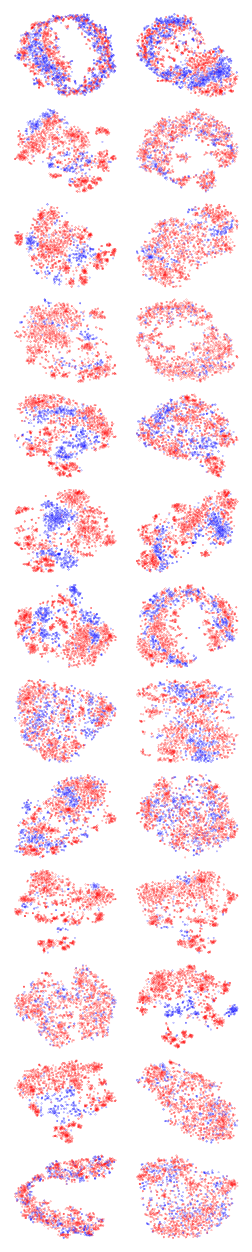

In [4]:
pretrain_method = ['dsrn', 
                     #    'ae_mmd',
                        'dsrn_mmd','dsn_mmd',
                     #    'ae_adv',
                        'dsrn_adv','dsn_adv'][4]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import entropy

plt.rcParams['font.size'] = 0.2

sigma = 1.0
def compute_mmd(A, B, sigma):
    # 计算高斯核矩阵
    K_A = np.exp(-cdist(A, A, 'sqeuclidean') / (2 * sigma ** 2))
    K_B = np.exp(-cdist(B, B, 'sqeuclidean') / (2 * sigma ** 2))
    K_AB = np.exp(-cdist(A, B, 'sqeuclidean') / (2 * sigma ** 2))
    # 计算 MMD
    return np.mean(K_A) + np.mean(K_B) - 2 * np.mean(K_AB)

def compute_kl_divergence(A, B):
    # 计算分布的概率密度函数
    p_A = np.histogramdd(A, bins=10, density=True)[0]
    p_B = np.histogramdd(B, bins=10, density=True)[0]
    # 计算 KL 散度
    return entropy(p_A.flatten(), p_B.flatten())

# 创建一个 5 行 5 列的子图
x_num , y_num = 13,2
fig, axs = plt.subplots(x_num , y_num,figsize=(3, 16))

MMD = np.empty((x_num,y_num))
# MMD2 = np.empty((x_num,y_num))
KL = np.empty((x_num,y_num))

# 填充每个子图
for i in range(x_num):
    for j in range(y_num):
         TT = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
            "luad", "lusc", "read", "sarc", "skcm","stad"][i] 
         pretrain_mode = ["tcga","match"][j]

         tsne = manifold.TSNE(n_components=2, init='random',random_state=0)
         ori_gex = pd.read_csv(f'../data/align_data/{pretrain_mode}/{pretrain_method}/{TT}.csv', index_col=0)

         gex_label = ori_gex.label.values
         color = np.array(['r'] * sum(gex_label == "CCLE") + ['b'] * sum(gex_label == "TCGA"))
         # color[np.where(Tumor_type_info == TT.upper())[0]] = 'r'
         # print(TT,sum(color == 'r'))
         # gex_label[gex_label=="TCGA"] = TT.upper()
         del ori_gex['label']
         ori_gex_y = tsne.fit_transform(ori_gex)
         ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
         ccle_feature_df = np.array(ori_encoder_feature_df.loc[color == 'r'])
         patient_feature_df = np.array(ori_encoder_feature_df.loc[color == 'b'])
         mmd = compute_mmd(ccle_feature_df, patient_feature_df, sigma)
        #  mmd2 = compute_mmd(patient_feature_df,ccle_feature_df, sigma)
         kl_divergence = compute_kl_divergence(ccle_feature_df,patient_feature_df)
         MMD[i,j] = mmd
        #  MMD2[i,j] = mmd2
         KL[i,j] = kl_divergence

         axs[i, j].scatter(x='x',y='y',data=ori_encoder_feature_df,c=color,s=0.02,alpha=1, marker='o')
         # axs[i, j].set_title(TT)
         axs[i,j].set_axis_off()

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.1, hspace=0.05)

# 显示图形
# plt.show()

plt.savefig(f'../data/align_data/tcga_vs_match.pdf', format='pdf', dpi=600,bbox_inches='tight')


In [35]:
arr = MMD
arr = np.concatenate([arr, arr[:, 0:1] / arr[:, 1:2]], axis=1)
arr

array([[0.00473569, 0.00773773, 0.61202627],
       [0.01352428, 0.00724399, 1.86696596],
       [0.01294019, 0.01044305, 1.23911941],
       [0.01817091, 0.00973249, 1.86703574],
       [0.00975818, 0.00699673, 1.39467623],
       [0.0109815 , 0.01120039, 0.98045757],
       [0.00981146, 0.01023364, 0.95874593],
       [0.00609155, 0.00930328, 0.65477503],
       [0.008767  , 0.0054907 , 1.59669918],
       [0.03069436, 0.02547791, 1.20474415],
       [0.00791456, 0.01953609, 0.40512497],
       [0.01495405, 0.00988122, 1.51338159],
       [0.0067605 , 0.00636815, 1.06161186]])

## 60组参数

In [5]:
select_method =  ['dsrn', 
                     #    'ae_mmd',
                        'dsrn_mmd','dsn_mmd',
                     #    'ae_adv',
                        'dsrn_adv','dsn_adv'][4]+"_norm"
pretrain_TT = ["tcga","brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
            "luad", "lusc", "read", "sarc", "skcm","stad"][0]
if pretrain_TT == "tcga":
    TT = "BRCA"
else:
    TT = pretrain_TT.upper()


import os
import glob
import json
import pandas as pd

file_dir = os.path.join("../results/classification",select_method,pretrain_TT,f"raw/Percent_sd/all_CCL/raw/{TT}/gdsc1_raw/overlap/AUC")

num=0
for json_name in glob.glob(os.path.join(file_dir, "*.json")):
    num = num+1
    # json_file = os.path.join(file_dir,json_name)
    json_file = json_name
    json_name = os.path.basename(json_file)
    with open(json_file, 'r') as f:
        metrics = json.load(f)
    metrics = pd.DataFrame(metrics)
    AUROC = pd.DataFrame(metrics['auroc']).T

    # print(AUROC)
    # print(json_name[:-27])

    AUROC.index = [json_name[:-27]]
    if num == 1 :
        All_AUROC = AUROC
    else :
        All_AUROC = pd.concat([All_AUROC,AUROC])
    
    # print(num,All_AUROC.index)


In [6]:
All_AUROC['mean'] = All_AUROC.mean(axis = 1)
All_AUROC = All_AUROC.sort_values(by='mean',ascending = False)
All_AUROC

,0,1,2,3,4,mean
pretrain_num_epochs_0_train_num_epochs_500_dop_0.1,0.647959,0.678571,0.525510,0.647959,0.668367,0.633673
pretrain_num_epochs_300_train_num_epochs_300_dop_0.0,0.647959,0.586735,0.551020,0.596939,0.596939,0.595918
pretrain_num_epochs_100_train_num_epochs_1000_dop_0.0,0.602041,0.596939,0.607143,0.612245,0.469388,0.577551
pretrain_num_epochs_100_train_num_epochs_3000_dop_0.1,0.602041,0.581633,0.581633,0.586735,0.530612,0.576531
pretrain_num_epochs_100_train_num_epochs_300_dop_0.1,0.581633,0.556122,0.571429,0.576531,0.545918,0.566327
pretrain_num_epochs_300_train_num_epochs_200_dop_0.0,0.642857,0.561224,0.551020,0.545918,0.515306,0.563265
pretrain_num_epochs_100_train_num_epochs_100_dop_0.1,0.596939,0.571429,0.581633,0.540816,0.489796,0.556122
pretrain_num_epochs_0_train_num_epochs_100_dop_0.1,0.576531,0.581633,0.556122,0.494898,0.489796,0.539796
pretrain_num_epochs_100_train_num_epochs_2500_dop_0.0,0.545918,0.596939,0.566327,0.556122,0.428571,0.538776
pretrain_num_epochs_0_train_num_epochs_1000_dop_0.0,0.515306,0.535714,0.520408,0.556122,0.566327,0.538776


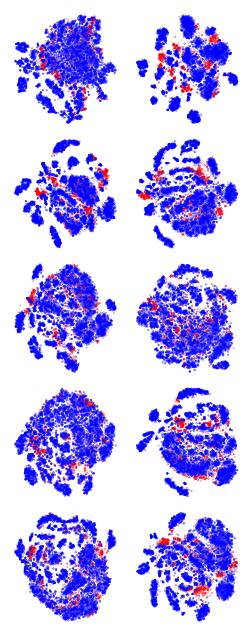

In [7]:
# All_AUROC.index[:5]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import entropy

plt.rcParams['font.size'] = 0.2

select_method =  ['dsrn', 
                     #    'ae_mmd',
                        'dsrn_mmd','dsn_mmd',
                     #    'ae_adv',
                        'dsrn_adv','dsn_adv'][4]
# pretrain_TT = ["tcga","brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
#             "luad", "lusc", "read", "sarc", "skcm","stad"][1]


# 创建一个 5 行 5 列的子图
x_num , y_num = 5,2
fig, axs = plt.subplots(x_num , y_num,figsize=(3, 8))

sigma = 1.0
def compute_mmd(A, B, sigma):
    # 计算高斯核矩阵
    K_A = np.exp(-cdist(A, A, 'sqeuclidean') / (2 * sigma ** 2))
    K_B = np.exp(-cdist(B, B, 'sqeuclidean') / (2 * sigma ** 2))
    K_AB = np.exp(-cdist(A, B, 'sqeuclidean') / (2 * sigma ** 2))
    # 计算 MMD
    return np.mean(K_A) + np.mean(K_B) - 2 * np.mean(K_AB)

def compute_kl_divergence(A, B):
    # 计算分布的概率密度函数
    p_A = np.histogramdd(A, bins=10, density=True)[0]
    p_B = np.histogramdd(B, bins=10, density=True)[0]
    # 计算 KL 散度
    return entropy(p_A.flatten(), p_B.flatten())

MMD1 = np.empty((x_num,y_num))
MMD2 = np.empty((x_num,y_num))
KL = np.empty((x_num,y_num))

# 填充每个子图
for i in range(x_num):
    for j in range(y_num):
         params_top = All_AUROC.index[:x_num][i]
         params_down = All_AUROC.index[-x_num:][i]
         if j == 0:
            params = params_top
         else:
             params = params_down
         tsne = manifold.TSNE(n_components=2, init='random',random_state=0)
         ori_gex = pd.read_csv(f'../results/encoded/{select_method}/{pretrain_TT}/{pretrain_TT}_{params}.csv', index_col=0)

         gex_label = ori_gex.label.values
         
         color = np.array(['r'] * sum(gex_label == "CCLE") + ['b'] * sum(gex_label == "TCGA"))
         # color[np.where(Tumor_type_info == TT.upper())[0]] = 'r'
         # print(TT,sum(color == 'r'))
         # gex_label[gex_label=="TCGA"] = TT.upper()
         del ori_gex['label']
         ori_gex_y = tsne.fit_transform(ori_gex)
         ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
         ccle_feature_df = np.array(ori_encoder_feature_df.loc[color == 'r'])
         patient_feature_df = np.array(ori_encoder_feature_df.loc[color == 'b'])
         mmd1 = compute_mmd(ccle_feature_df, patient_feature_df, sigma)
         mmd2 = compute_mmd(patient_feature_df,ccle_feature_df, sigma)
         kl_divergence = compute_kl_divergence(ccle_feature_df,patient_feature_df)
         MMD1[i,j] = mmd1
         MMD2[i,j] = mmd2
         KL[i,j] = kl_divergence

         axs[i, j].scatter(x='x',y='y',data=ori_encoder_feature_df,c=color,s=0.02,alpha=1, marker='o')
         # axs[i, j].set_title(TT)
         axs[i,j].set_axis_off()

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.1, hspace=0.05)

# 显示图形
# plt.show()

plt.savefig(f'../results/encoded/1.pdf', format='pdf', dpi=600,bbox_inches='tight')


In [27]:
MMD1

array([[0.00963062, 0.0127394 ],
       [0.01308956, 0.01027221],
       [0.01822992, 0.00932793],
       [0.00853956, 0.0107621 ],
       [0.01157355, 0.0110194 ]])

In [28]:
MMD2

array([[0.00963062, 0.0127394 ],
       [0.01308956, 0.01027221],
       [0.01822992, 0.00932793],
       [0.00853956, 0.0107621 ],
       [0.01157355, 0.0110194 ]])

In [25]:
KL

array([[inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf]])

In [16]:
import numpy as np
from scipy.spatial.distance import cdist

# https://depmap.org/portal/celligner/
A = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
B = np.array([[2, 3], [4, 5], [6, 7]])
D = cdist(A, B)
A

array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8]])

In [15]:
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import entropy

sigma = 1.0
def compute_mmd(A, B, sigma):
    # 计算高斯核矩阵
    K_A = np.exp(-cdist(A, A, 'sqeuclidean') / (2 * sigma ** 2))
    K_B = np.exp(-cdist(B, B, 'sqeuclidean') / (2 * sigma ** 2))
    K_AB = np.exp(-cdist(A, B, 'sqeuclidean') / (2 * sigma ** 2))
    # 计算 MMD
    return np.mean(K_A) + np.mean(K_B) - 2 * np.mean(K_AB)

def compute_kl_divergence(A, B):
    # 计算分布的概率密度函数
    p_A = np.histogramdd(A, bins=10, density=True)[0]
    p_B = np.histogramdd(B, bins=10, density=True)[0]
    # 计算 KL 散度
    return entropy(p_A.flatten(), p_B.flatten())


A = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
B = np.array([[2, 3], [4, 5], [6, 7]])


mmd = compute_mmd(A, B, sigma)
kl_divergence = compute_kl_divergence(B,A)
print(mmd,kl_divergence)

0.23038032062997144 inf


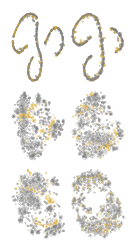

In [12]:
TT = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
            "luad", "lusc", "read", "sarc", "skcm","stad"][3]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import entropy

plt.rcParams['font.size'] = 0.2

sigma = 1.0
def compute_mmd(A, B, sigma):
    # 计算高斯核矩阵
    K_A = np.exp(-cdist(A, A, 'sqeuclidean') / (2 * sigma ** 2))
    K_B = np.exp(-cdist(B, B, 'sqeuclidean') / (2 * sigma ** 2))
    K_AB = np.exp(-cdist(A, B, 'sqeuclidean') / (2 * sigma ** 2))
    # 计算 MMD
    return np.mean(K_A) + np.mean(K_B) - 2 * np.mean(K_AB)

def compute_kl_divergence(A, B):
    # 计算分布的概率密度函数
    p_A = np.histogramdd(A, bins=10, density=True)[0]
    p_B = np.histogramdd(B, bins=10, density=True)[0]
    # 计算 KL 散度
    return entropy(p_A.flatten(), p_B.flatten())

# 创建一个 5 行 5 列的子图
x_num , y_num = 3,2
fig, axs = plt.subplots(x_num , y_num,figsize=(1.5,3))

MMD = np.empty((x_num,y_num))
# MMD2 = np.empty((x_num,y_num))
KL = np.empty((x_num,y_num))

# 填充每个子图
for i in range(x_num):
    for j in range(y_num):
         pretrain_method = ['ae_adv','dsrn_adv','dsn_adv'][i]

         pretrain_mode = ["tcga","match"][j]

         tsne = manifold.TSNE(n_components=2, init='random',random_state=0)
         ori_gex = pd.read_csv(f'../data/align_data/{pretrain_mode}/{pretrain_method}/{TT}.csv', index_col=0)

         gex_label = ori_gex.label.values
         color = np.array(['grey'] * sum(gex_label == "CCLE") + ['goldenrod'] * sum(gex_label == "TCGA"))
         # color[np.where(Tumor_type_info == TT.upper())[0]] = 'r'
         # print(TT,sum(color == 'r'))
         # gex_label[gex_label=="TCGA"] = TT.upper()
         del ori_gex['label']
         ori_gex_y = tsne.fit_transform(ori_gex)
         ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
         ccle_feature_df = np.array(ori_encoder_feature_df.loc[color == 'grey'])
         patient_feature_df = np.array(ori_encoder_feature_df.loc[color == 'goldenrod'])
         mmd = compute_mmd(ccle_feature_df, patient_feature_df, sigma)
        #  mmd2 = compute_mmd(patient_feature_df,ccle_feature_df, sigma)
         kl_divergence = compute_kl_divergence(ccle_feature_df,patient_feature_df)
         MMD[i,j] = mmd
        #  MMD2[i,j] = mmd2
         KL[i,j] = kl_divergence

         axs[i, j].scatter(x='x',y='y',data=ori_encoder_feature_df,c=color,s=0.02,alpha=1, marker='o')
         # axs[i, j].set_title(TT)
         axs[i,j].set_axis_off()

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# 显示图形
# plt.show()

plt.savefig(f'../data/align_data/adv_{TT}.pdf', format='pdf', dpi=1200,bbox_inches='tight')
# plt.savefig(f'../data/align_data/adv_{TT}.png', format='png', dpi=1200,bbox_inches='tight')


## 生成数据集

In [ ]:
select_gene_num = 1000
pretrain_dataset_list = ["tcga","brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
          "luad", "lusc", "read", "sarc", "skcm","stad"]

import data

for pretrain_dataset in pretrain_dataset_list:
    print(pretrain_dataset)
    gex_features_df,CCL_tumor_type,all_ccle_gex,all_patient_gex = data.get_pretrain_dataset(
        patient_tumor_type = pretrain_dataset,
        CCL_type = "all_CCL",
        tumor_type = "a", #all_CCL应该就没用，只听pretrain_dataset
        tcga_construction = "raw",
        CCL_construction = "raw",
        gene_num = select_gene_num,select_gene_method = "Percent_sd"
        )
    gex_features_df.to_csv(f'../data/align_data/{pretrain_dataset}_pretrain_dataset.csv')

### 再去0_plot中判断最好的params，生成param_list_tcga[match]文件
### 最后调用generate_encoded_features.py生成128维隐层表示

### 生成Orginal dataset：不筛选基因，所有基因

In [14]:
pretrain_dataset_list = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
          "luad", "lusc", "read", "sarc", "skcm","stad"]
patient_gex_raw = pd.read_csv("../data/preprocessed_dat/xena_gex_raw.csv", index_col=0)  #9808TCGA_sample * 18966HVG(overlap)
ccle_gex_raw = pd.read_csv("../data/preprocessed_dat/ccle_gex_raw.csv", index_col=0)  #1305CCL_sample * 18966HVG(overlap)

patient_sample_info = pd.read_csv("../data/preprocessed_dat/xena_sample_info.csv", index_col=0) 
# ccle_sample_info = pd.read_csv("../data/preprocessed_dat/ccle_sample_info.csv", index_col=0) 

for pretrain_dataset in pretrain_dataset_list:
    print(pretrain_dataset)
    patient_tumor_type = pretrain_dataset.upper() 
    patient_samples = patient_gex_raw.index.intersection(patient_sample_info.loc[patient_sample_info.tumor_type == patient_tumor_type].index)
    patient_gex = patient_gex_raw.loc[patient_samples]

    gex_features_df = pd.concat([patient_gex,ccle_gex_raw])
    gex_features_df.to_csv(f'../data/align_data/orginal/{pretrain_dataset}_dataset.csv')

brca
cesc
coad
gbm
hnsc
kirc
lgg
luad
lusc
read
sarc
skcm
stad
